<a href="https://colab.research.google.com/github/Khey17/100-Days-Of-ML-Code/blob/main/Learn-TensorFlow/NLP_Fundamentals_in_TensorFlow_08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Natural Language Processing Fundamentals in TensorFlow

NLP has the goal of deriving information out of natural language (could be sequences text or speech).

Another common term for NLP problems is sequence to sequence problems (seq2sep)
E.g. One-2-One, Many-2-One, and so on...

### Check for GPU

In [1]:
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


## Get helper functions

In [2]:
!wget https://raw.githubusercontent.com/Khey17/100-Days-Of-ML-Code/main/Learn-TensorFlow/HelperFunctions/helper.py

# Import series of helper functions for the notebook
from helper import *

--2024-03-28 11:45:25--  https://raw.githubusercontent.com/Khey17/100-Days-Of-ML-Code/main/Learn-TensorFlow/HelperFunctions/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16635 (16K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]  16.25K  --.-KB/s    in 0.001s  

2024-03-28 11:45:25 (29.7 MB/s) - ‘helper.py’ saved [16635/16635]



## Get a text dataset

The dataset we're going to be using is Kaggle's introduction to NLP dataset (text samples of Tweets labelled as disaster or not disaster).

[Kaggle Competition](https://www.kaggle.com/competitions/nlp-getting-started)

In [8]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

# Unzip data
DataHandler.unzip_data('nlp_getting_started.zip')

--2024-03-28 11:53:18--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.210.207, 173.194.211.207, 173.194.212.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.210.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.004s  

2024-03-28 11:53:18 (134 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



### Visualizing a text dataset

To visualize our text samples, we first have to read them in, one way to use pandas.

In [9]:
import pandas as pd

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [10]:
# shuffling our training data
train_df = train_df.sample(frac=1, random_state=42)
train_df.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [11]:
# What does our test dataframe look like?
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [12]:
# How many examples of each class?
train_df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [13]:
# Total samples
len(train_df), len(test_df)

(7613, 3263)

In [16]:
# Let's visualize some random training examples
import random

random_idx = random.randint(0, len(train_df) - 5)
for row in train_df[['text', 'target']][random_idx:random_idx + 5].itertuples():

    _, text, target = row
    print(f'Target: {target}', "(real disaster)" if target > 0 else "(not real disaster)")
    print(f'Text:\n {text}\n')

    print('---\n')

Target: 1 (real disaster)
Text:
 Denali wolf population declined from 143 in 2007 2 just 48 in 2015. Reinstate emergency buffer zone #ProtectDenaliWolves @Alaska @adndotcom

---

Target: 0 (not real disaster)
Text:
 Last Chance Animal Rescue has 3 new posts. http://t.co/f1tcbg1MKi #animalrescue | https://t.co/Is2iDC3UBJ

---

Target: 0 (not real disaster)
Text:
 Watch Sarah Palin OBLITERATE Planned Parenthood For Targeting Minority Women! ÛÒ BB4SP http://t.co/sAYZt2oagm

---

Target: 0 (not real disaster)
Text:
 Emergency root canal!! #tookitlikeaman #lovemydentist #sore

---

Target: 0 (not real disaster)
Text:
 Stats http://t.co/U7vavyrGv9

---



### Split data into training and validation sets

In [18]:
from sklearn.model_selection import train_test_split

train_sen, val_sen, train_labels, val_labels = train_test_split(train_df['text'].to_numpy(),
                                                                train_df['target'].to_numpy(),
                                                                test_size=0.1, random_state=42)
# Check the lengths
len(train_sen), len(train_labels), len(val_sen), len(val_labels)

(6851, 6851, 762, 762)

In [20]:
# Check the first 10 samples
train_sen[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

### Converting text into numbers

When dealing with a text problem, one of the first things you'll have to do before you can build a model is to convert the text into numbers.

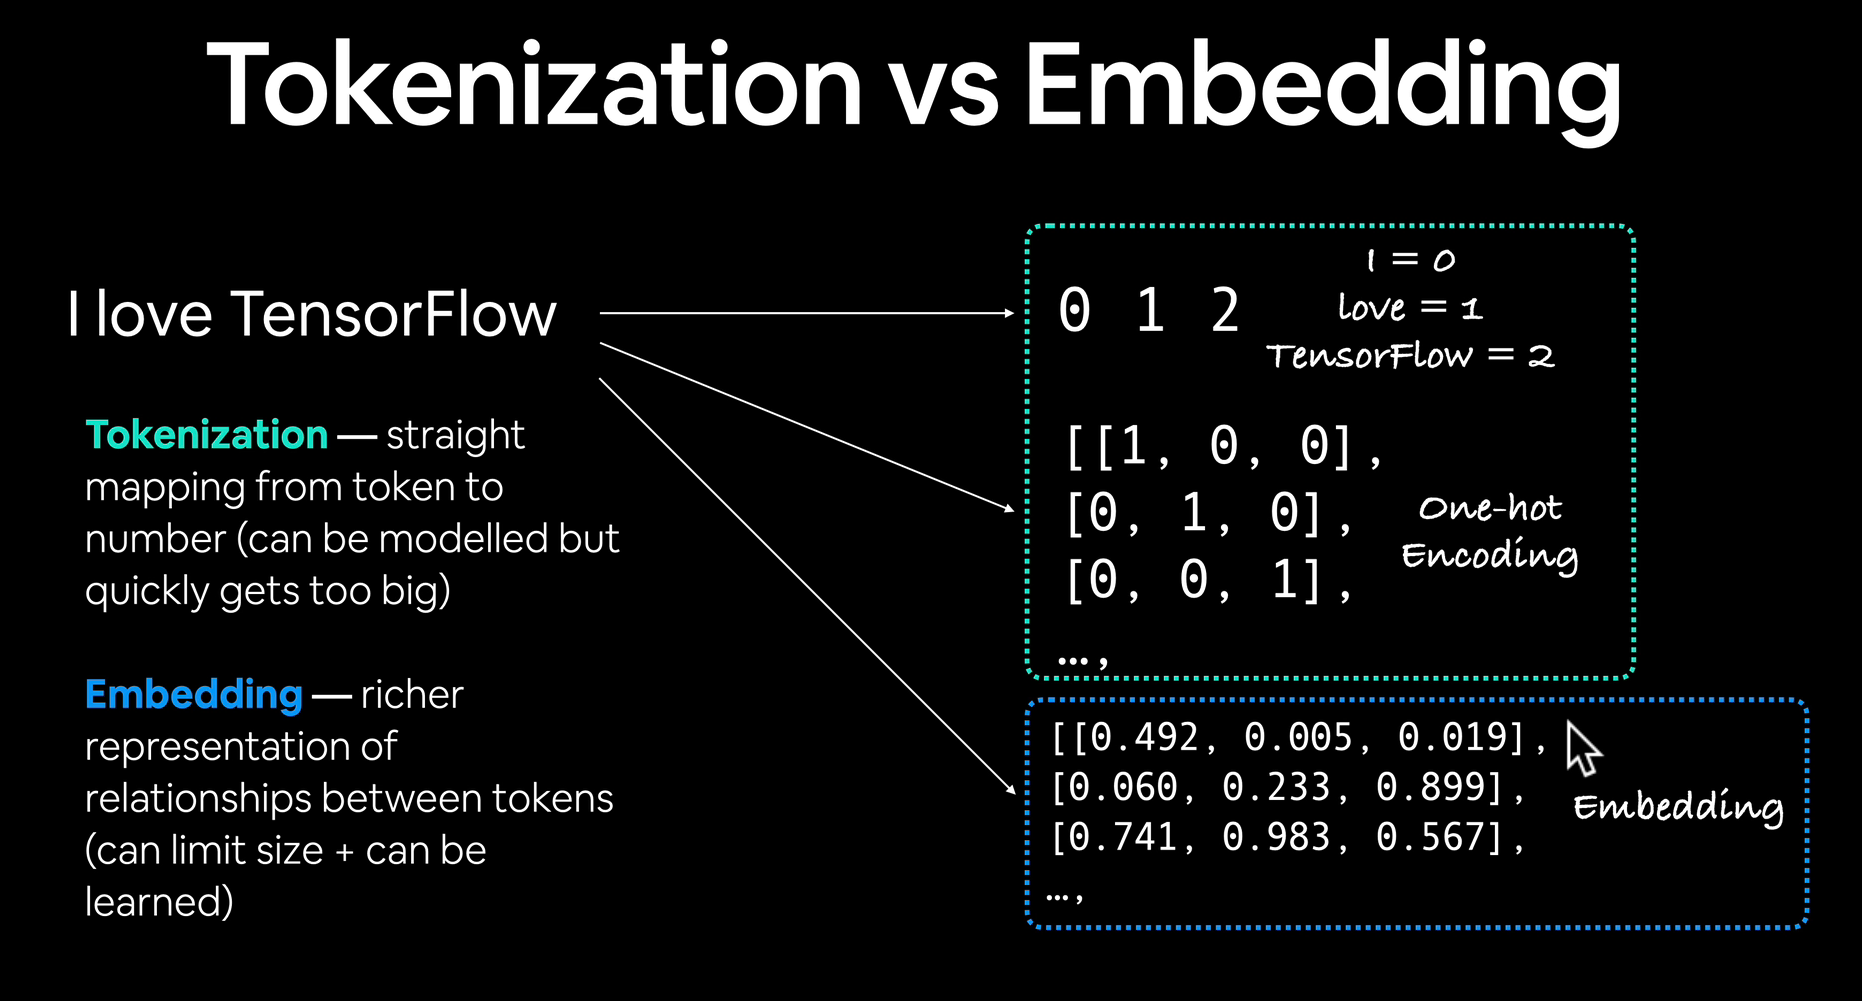

### Text vectorization (Tokenization)

In [21]:
train_sen[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [25]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

# Use the default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=10000,  # how many words in the vocabulary (automatically add <OOV>)
                                    standardize='lower_and_strip_punctuation', split='whitespace',
                                    ngrams=None,  # creates groups of n-words
                                    output_mode='int',  # how to map tokens to numbers
                                    output_sequence_length=None,  # how long do you want your sequences to be
                                    pad_to_max_tokens=True)

In [26]:
len(train_sen[0].split())

7

In [28]:
# Find the average number of tokens (words) in the training tweets
round(sum([len(i.split()) for i in train_sen])/len(train_sen))

15

In [30]:
# Setup text vectorization variables
max_vocab_length = 10000 # @param {type:"slider", min:2000, max:10000, step:2000}
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does a model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode='int',
                                    output_sequence_length=max_length)

# Fit the text vectorizer to the training data
text_vectorizer.adapt(train_sen)  # adapt the text vectorizer to the training data

In [31]:
# Create a sample sentence and tokenize it
sample_sentence = "There is a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 74,   9,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [35]:
# Choose a random sentence from the training data
random_sentence = random.choice(train_sen)
print(f'Original text:\n {random_sentence}\
        \n\nVectorized version:\n {text_vectorizer([random_sentence])}')

Original text:
 Enter the world of extreme diving ÛÓ 9 stories up and into the Volga River http://t.co/vz19VvgMnv        

Vectorized version:
 [[3026    2  107    6 1527 2491  694  491 1172   27    7   66    2 3269
   499]]


In [37]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()  # get all of the unique words from the training data
print(f'Number of unique words in the vocabulary: {len(words_in_vocab)}')  # print the number of unique words in the vocabulary

top_5_words = words_in_vocab[:5]  # get the top 5 words
print(f'Top 5 words in the vocabulary:\n {top_5_words}')

bottom_5_words = words_in_vocab[-5:]  # get the bottom 5 words
print(f'Bottom 5 words in the vocabulary:\n {bottom_5_words}')

Number of unique words in the vocabulary: 10000
Top 5 words in the vocabulary:
 ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 words in the vocabulary:
 ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


### Creating an Embedding using an Embedding layer

To make our embedding, we're going to use TensorFlow's [tf.keras.layers.Embedding](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding) layer

The parameters we care most about for our embedding layer:
* `input_dim` = the size of our vocabulary
* `output_dim` = the size of the output embedding vector, for example, a avalue of 100 would mean each token gets represented by a vector 100 long
* `input_length` = length of the sequences being passed to the embedding layer

In [46]:
from tensorflow.keras.layers import Embedding

embedding = Embedding(input_dim=max_vocab_length,  # set input shape
                            output_dim=128,  # set output shape
                            embeddings_initializer='uniform',  # set initializer
                            input_length=max_length  # how long is each input
                            )
embedding

In [47]:
# Get a random sentence from the training set
random_sentence = random.choice(train_sen)
print(f'Original text:\n {random_sentence}\
        \n\nEmbedded version:\n {embedding(text_vectorizer([random_sentence]))}\n Tensor Shape: {embedding(text_vectorizer([random_sentence])).shape}')  # vectorize the sentence

Original text:
 There is no greater tragedy than becoming comfortable with where you are in life.        

Embedded version:
 [[[ 0.00622339  0.00965738  0.01571175 ...  0.00112485  0.00438489
    0.00334669]
  [ 0.0251058  -0.02863349 -0.01122184 ...  0.01056623  0.03808824
    0.01426909]
  [ 0.03066165  0.03613483 -0.00061495 ...  0.00928431 -0.02796029
    0.00322878]
  ...
  [ 0.00862653 -0.03551588 -0.01457755 ...  0.01035433  0.00782521
    0.01316554]
  [-0.03149758 -0.04683566  0.01791683 ...  0.00618887 -0.02693502
    0.03444675]
  [ 0.01813339 -0.02732353 -0.02627042 ... -0.02710015 -0.04852868
    0.03765548]]]
 Tensor Shape: (1, 15, 128)


In [48]:
# Check out a single token's embedding
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 0.00622339,  0.00965738,  0.01571175,  0.02967601, -0.03542663,
        -0.04060887,  0.02846542,  0.03054013, -0.0474097 , -0.04444358,
        -0.0332337 , -0.01788968,  0.00275014, -0.01102834, -0.02705623,
        -0.03012855, -0.04911279,  0.03107596, -0.03678286,  0.00196307,
        -0.0020622 ,  0.0450611 ,  0.03220204, -0.02310234, -0.03904323,
         0.04664642, -0.03479611, -0.00644217, -0.04602392, -0.02537596,
        -0.0092987 ,  0.0424315 , -0.03192924, -0.0342975 , -0.01710405,
        -0.00510051,  0.03041256, -0.01906619,  0.00624213, -0.00946522,
         0.01268692,  0.00440562, -0.00919986,  0.03488995,  0.04817332,
        -0.04528655, -0.01800727,  0.04748044,  0.00133194,  0.02923821,
        -0.00912759, -0.02641778,  0.03006056,  0.04312142,  0.03374139,
         0.0367027 , -0.0190379 ,  0.0099427 ,  0.02801091, -0.04466081,
         0.00216212, -0.00611945, -0.00187733, -0.01323581, -0.01128951,
  

## Modelling a text dataset (running a series of experiments)

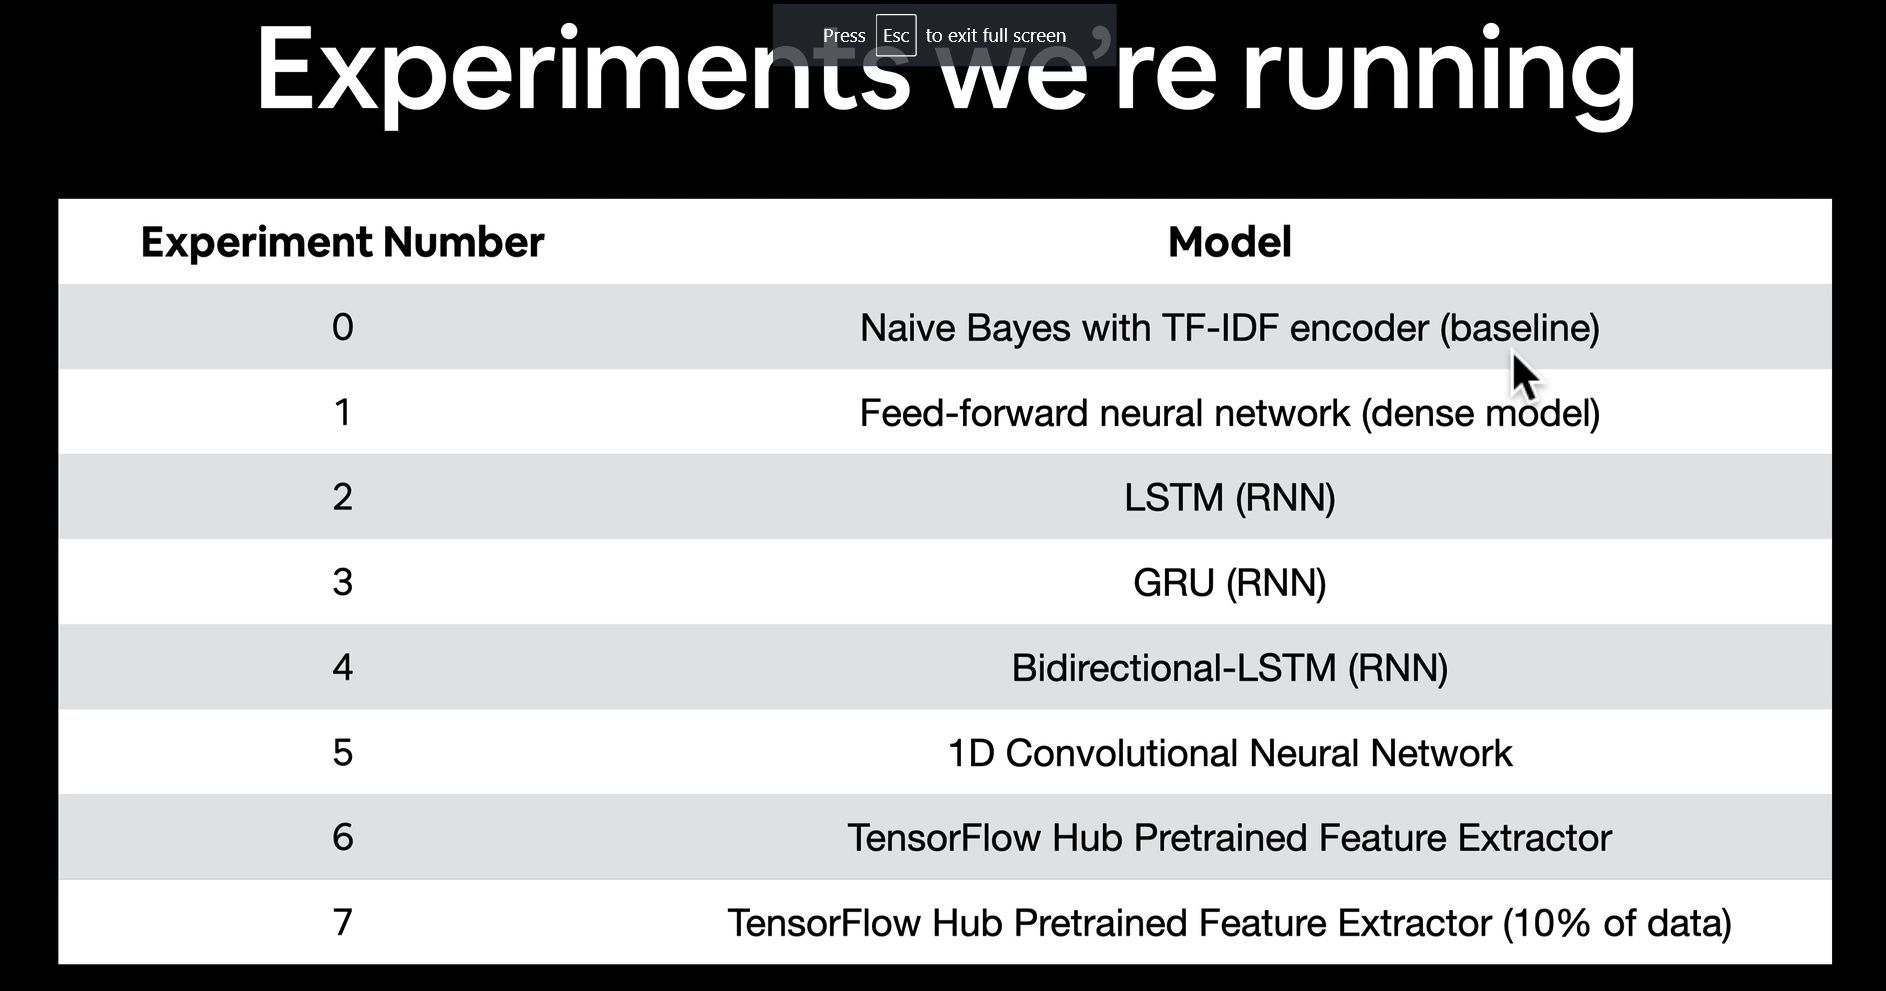

Now we've got a way to turn our text sequences into numbers, it's time to start building a series of modelling experiments.

We'll start with a baseline and move on from there.

* Model_0: Naive Bayes (baseline), this is from [Sklearn ML map](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)
* Model_1: Feed-Forward neural network (dense model)
* Model_2: LSTM model (RNN)
* Model_3: GRU model (RNN)
* Model_4: Bidirectional-LSTM model (RNN)
* Model_5: 1D Convolutional Neural Network (CNN)
* Model_6: TensorFlow Hub Pretrained Feature Extractor (using transfer learning for NLP)
* Model_7: Same as model 6 with 10% of training data

How are we going to approach all of these?

Use the standard steps in modelling tensorFlow:
* Create a model
* Build a model
* Fit a model
* Evaluate our model

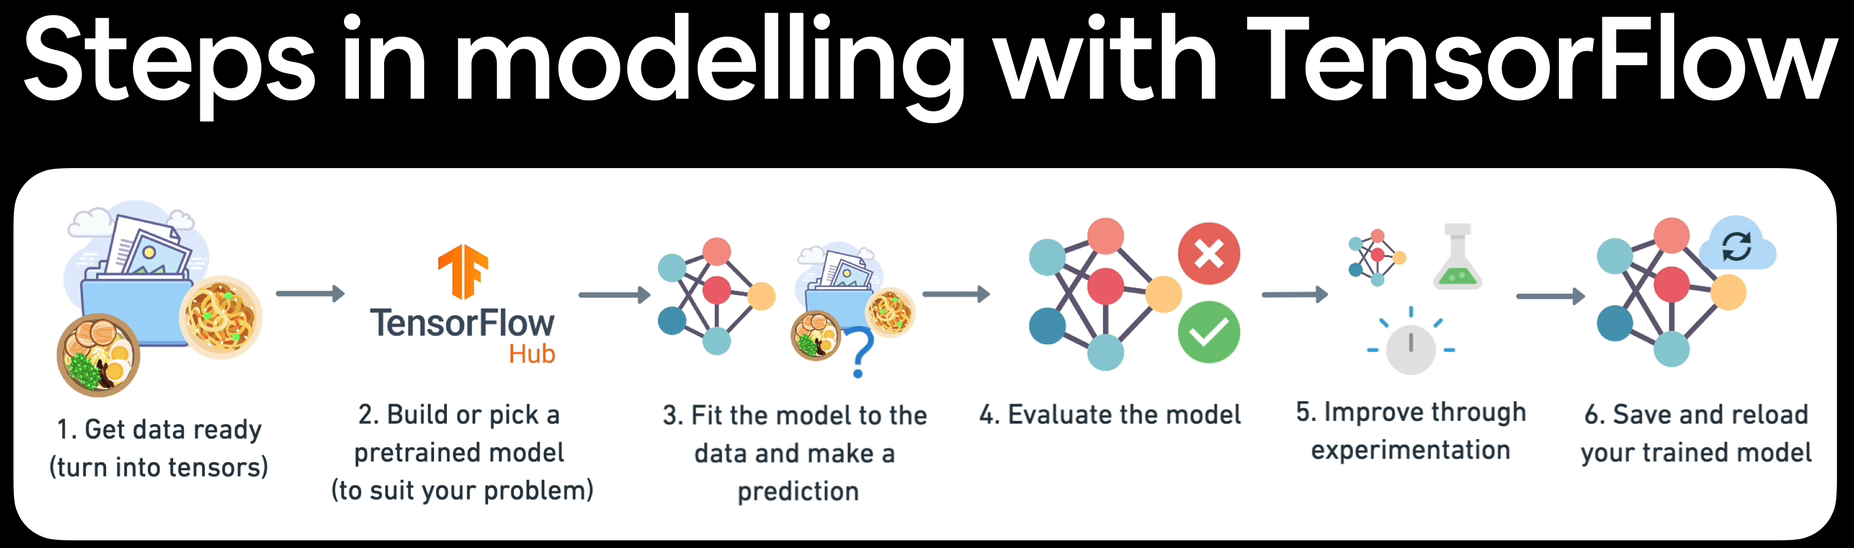

In [56]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(train_sen)
X_train_counts.shape

(6851, 20076)

In [57]:
X_train_counts

<6851x20076 sparse matrix of type '<class 'numpy.int64'>'
	with 100227 stored elements in Compressed Sparse Row format>

In [58]:
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=False).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_train_tf.shape, X_train_tf

((6851, 20076),
 <6851x20076 sparse matrix of type '<class 'numpy.float64'>'
 	with 100227 stored elements in Compressed Sparse Row format>)

In [59]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(6851, 20076)

In [60]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, train_labels)